In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TEMEL FONKSİYONLAR

In [3]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 64

def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test



# VERİ ÖN İŞLEME

In [4]:
import h5py

In [5]:
houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

In [6]:
X = np.array(houston18_file['ori_data'])
y = np.array(houston18_gt_file['map'])

In [7]:
X = np.transpose(X, (1, 2, 0))

In [8]:
y.shape

(954, 210)

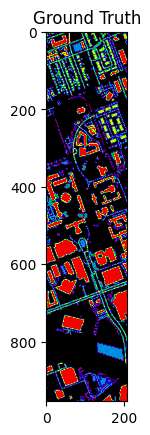

In [9]:
plt.imshow(y,cmap='nipy_spectral')
plt.title("Ground Truth")
plt.show()

In [10]:

X=applyPCA(X)

X,y=createPatch(X,y)

print(X.shape)
print(y.shape)

(53200, 15, 25, 25)
(53200,)


** Triplet Loss için ön işleme**

In [ ]:
X_df = pd.DataFrame(X.reshape(X.shape[0], -1))
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['class'] = y.ravel()

y_df= df['class']
X_train_df,X_val_df,X_test_df,y_train_df,y_val_df,y_test_df=splitTrainTestSet(X_df,y_df)

print(X_train_df.shape)
print(X_val_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_val_df.shape)
print(y_test_df.shape)


### görsel ön işlemi

columns = ['archor_img','postive_img','close_positive_img','negative_img','label']
df_train_for_triplet=pd.DataFrame(columns=columns)
df_test_for_triplet=pd.DataFrame(columns=columns)
df_val_for_triplet=pd.DataFrame(columns=columns)

val_df=pd.concat([X_val_df,y_val_df],axis=1)
train_df=pd.concat([X_train_df, y_train_df], axis=1)
test_df=pd.concat([X_test_df,y_test_df],axis=1)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

train_df_reset_index= train_df.reset_index()
test_df_reset_index = test_df.reset_index()
val_df_reset_index = val_df.reset_index()



(15960, 9375)
(22344, 9375)
(14896, 9375)
(15960,)
(22344,)
(14896,)
(15960, 9376)
(14896, 9376)
(22344, 9376)


In [ ]:
for index, row in train_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1
       while(index_2 <train_df_reset_index.shape[0]-1 and train_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <train_df_reset_index.shape[0]-1):
            positive = train_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,train_df_reset_index.shape[0])
            while(train_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,train_df_reset_index.shape[0])
            negative = train_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_train_for_triplet=df_train_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_train_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,10757.0,10757.0,4132.0,43535.0,4.0
1,52254.0,52254.0,9054.0,47414.0,5.0
2,9054.0,9054.0,28892.0,27285.0,5.0
3,10041.0,10041.0,9364.0,25640.0,6.0
4,28892.0,28892.0,42450.0,27412.0,5.0
...,...,...,...,...,...
15947,21962.0,21962.0,37194.0,6924.0,5.0
15948,37194.0,37194.0,44732.0,6412.0,5.0
15949,16850.0,16850.0,38158.0,42770.0,2.0
15950,6265.0,6265.0,11284.0,15919.0,4.0


In [ ]:
df_train_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,10757.0,10757.0,4132.0,43535.0,4.0
1,52254.0,52254.0,9054.0,47414.0,5.0
2,9054.0,9054.0,28892.0,27285.0,5.0
3,10041.0,10041.0,9364.0,25640.0,6.0
4,28892.0,28892.0,42450.0,27412.0,5.0
...,...,...,...,...,...
15947,21962.0,21962.0,37194.0,6924.0,5.0
15948,37194.0,37194.0,44732.0,6412.0,5.0
15949,16850.0,16850.0,38158.0,42770.0,2.0
15950,6265.0,6265.0,11284.0,15919.0,4.0


In [ ]:
df_train_for_triplet.to_csv('veri_houston_train.csv')

In [ ]:
for index, row in test_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1
       while(index_2 < test_df_reset_index.shape[0]-1 and test_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <test_df_reset_index.shape[0]-1):
            positive = test_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,test_df_reset_index.shape[0])
            while(test_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,test_df_reset_index.shape[0])
            negative = test_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_test_for_triplet=df_test_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_test_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,16272.0,16272.0,3852.0,50386.0,6.0
1,7327.0,7327.0,4354.0,8911.0,4.0
2,25501.0,25501.0,26522.0,52434.0,5.0
3,26522.0,26522.0,40027.0,5736.0,5.0
4,40027.0,40027.0,32296.0,8642.0,5.0
...,...,...,...,...,...
14883,52160.0,52160.0,29918.0,27343.0,5.0
14884,29918.0,29918.0,29445.0,50248.0,5.0
14885,29445.0,29445.0,34755.0,40186.0,5.0
14886,34755.0,34755.0,35669.0,22101.0,5.0


In [ ]:
df_test_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,16272.0,16272.0,3852.0,50386.0,6.0
1,7327.0,7327.0,4354.0,8911.0,4.0
2,25501.0,25501.0,26522.0,52434.0,5.0
3,26522.0,26522.0,40027.0,5736.0,5.0
4,40027.0,40027.0,32296.0,8642.0,5.0
...,...,...,...,...,...
14883,52160.0,52160.0,29918.0,27343.0,5.0
14884,29918.0,29918.0,29445.0,50248.0,5.0
14885,29445.0,29445.0,34755.0,40186.0,5.0
14886,34755.0,34755.0,35669.0,22101.0,5.0


In [ ]:
df_test_for_triplet.to_csv('veri_houston_test.csv')

In [ ]:
for index, row in val_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1

       while(index_2 < val_df_reset_index.shape[0]-1 and val_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <val_df_reset_index.shape[0]-1):
            positive = val_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,val_df_reset_index.shape[0])
            while(val_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,val_df_reset_index.shape[0])
            negative = val_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_val_for_triplet=df_val_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_val_for_triplet.to_csv('veri_houston_val.csv')

In [ ]:
df_val_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,3309.0,3309.0,41172.0,16869.0,5.0
1,41172.0,41172.0,34639.0,47112.0,5.0
2,34639.0,34639.0,49923.0,3781.0,5.0
3,49923.0,49923.0,4894.0,7911.0,5.0
4,13848.0,13848.0,6505.0,3325.0,4.0
...,...,...,...,...,...
22331,21127.0,21127.0,34750.0,46381.0,5.0
22332,5333.0,5333.0,40916.0,10826.0,6.0
22333,34750.0,34750.0,32452.0,18319.0,5.0
22334,32452.0,32452.0,23026.0,23896.0,5.0


In [ ]:
df_val_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,3309.0,3309.0,41172.0,16869.0,5.0
1,41172.0,41172.0,34639.0,47112.0,5.0
2,34639.0,34639.0,49923.0,3781.0,5.0
3,49923.0,49923.0,4894.0,7911.0,5.0
4,13848.0,13848.0,6505.0,3325.0,4.0
...,...,...,...,...,...
22331,21127.0,21127.0,34750.0,46381.0,5.0
22332,5333.0,5333.0,40916.0,10826.0,6.0
22333,34750.0,34750.0,32452.0,18319.0,5.0
22334,32452.0,32452.0,23026.0,23896.0,5.0


In [ ]:
df_test_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,2617.0,2617.0,2716.0,1307.0,4.0
1,2716.0,2716.0,2707.0,2138.0,4.0
2,277.0,277.0,587.0,2785.0,3.0
3,514.0,514.0,187.0,821.0,6.0
4,2389.0,2389.0,500.0,2226.0,11.0
...,...,...,...,...,...
773,1831.0,1831.0,1912.0,693.0,12.0
774,1708.0,1708.0,1544.0,2707.0,1.0
775,1912.0,1912.0,568.0,1943.0,12.0
776,2563.0,2563.0,1941.0,1866.0,8.0


In [ ]:
df_val_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,1074.0,1074.0,1061.0,1431.0,14.0
1,748.0,748.0,738.0,1375.0,13.0
2,738.0,738.0,845.0,1085.0,13.0
3,1494.0,1494.0,1503.0,2330.0,2.0
4,2164.0,2164.0,1945.0,2508.0,12.0
...,...,...,...,...,...
1168,2231.0,2231.0,1407.0,1454.0,0.0
1169,2784.0,2784.0,81.0,240.0,8.0
1170,1745.0,1745.0,1611.0,2628.0,5.0
1171,1457.0,1457.0,1462.0,643.0,2.0


# Triplet Ön işleme bitiş

# Verilerin alınması ve CNN için hazırlıklar

In [11]:
df_train_for_triplet = pd.read_csv('veri_houston_train.csv',index_col=0)
df_test_for_triplet = pd.read_csv('veri_houston_test.csv',index_col=0)
df_val_for_triplet = pd.read_csv('veri_houston_val.csv',index_col=0)

indices_train = df_train_for_triplet.iloc[:, 1].astype(int).values
indices_test = df_test_for_triplet.iloc[:,1].astype(int).values
indices_val = df_val_for_triplet.iloc[:,1].astype(int).values

X_Train = X[indices_train]
X_Val = X[indices_val]
X_Test = X[indices_test]
y_Train = y[indices_train]
y_Val = y[indices_val]
y_Test = y[indices_test]

# Veriler tamam

# Veri Seti Kurgusu ve Dataloader İşlemleri

In [12]:
class HSIDataset():

    def __init__(self, datafr,X_np,train=True):
        self.data = datafr
        self.X_np = X_np


        self.anchorimages = datafr.iloc[:, 0].values
        self.anchorlabels = datafr.iloc[:, 4].values
        self.positiveimages = datafr.iloc[:, 2].values
        self.negativeimages = datafr.iloc[:, 3].values
        self.index = datafr.index.values

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):


        anchor_image_index = self.anchorimages[item]
        anchor_image_index=int(anchor_image_index)
        anchor_img = self.X_np[anchor_image_index]


        anchor_label = self.anchorlabels[item]



        positive_image_index = self.positiveimages[item]
        positive_image_index=int(positive_image_index)
        positive_img =self.X_np[positive_image_index]



        negative_image_index = self.negativeimages[item]
        negative_image_index=int(negative_image_index)
        negative_img = self.X_np[negative_image_index]

        anchor_img_tensor = torch.tensor(anchor_img)
        positive_img_tensor = torch.tensor(positive_img)
        negative_img_tensor = torch.tensor(negative_img)
        anchor_label_tensor = torch.tensor(anchor_label)


        anchor_img_tensor=anchor_img_tensor.float()
        positive_img_tensor=positive_img_tensor.float()
        negative_img_tensor=negative_img_tensor.float()
        anchor_label_tensor=anchor_label_tensor.float()

        return anchor_img_tensor, positive_img_tensor, negative_img_tensor, anchor_label_tensor





def get_train_dataset():
    train_dataset = HSIDataset(df_train_for_triplet,X)
    return train_dataset

def get_test_dataset():
    test_dataset = HSIDataset(df_test_for_triplet,X)
    return test_dataset

def get_val_dataset():
    val_dataset = HSIDataset(df_val_for_triplet,X)
    return val_dataset



from torch.utils.data import DataLoader
train_dataset=get_train_dataset()
train_dl = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

val_dataset = get_val_dataset()

val_dl = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

test_dataset = get_test_dataset()

test_dl = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)



# Network Oluşturma ve Loss Function

In [13]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x



class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,256)
        self.relu1=nn.ReLU(inplace=True)
        self.fc9=nn.Linear(256,512)
        self.relu2=nn.ReLU(inplace=True)
        self.fc10=nn.Linear(512,128)
        self.relu3=nn.ReLU(inplace=True)
        self.fc11=nn.Linear(128,64)
        self.relu4=nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 7)

    def forward(self, x):

        x = self.fc8(x)
        x=self.relu1(x)
        x = self.fc9(x)
        x=self.relu2(x)
        x = self.fc10(x)
        x=self.relu3(x)
        x = self.fc11(x)
        x=self.relu4(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x


a = nn.TripletMarginLoss()




# 1. Network için eğitim Aşaması

In [14]:
def evaluate(model, val_dl, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = []
        running_acc = []


        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_dl, desc="Evaluating", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)


            loss = triplet_loss

            running_loss.append(loss.item())



        avg_loss = sum(running_loss) / len(running_loss)


    return avg_loss


def train(model, train_dl, val_dl, loss_fn, optimizer, device):


    train_loss = []
    val_loss = []

    model.train()
    best_val_acc = 0.0
    for epoch in tqdm(range(20), desc="Epochs"):
        running_loss = []

        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)


            running_loss.append(triplet_loss.item())

            optimizer.zero_grad()
            triplet_loss.backward()
            optimizer.step()


        avg_loss = sum(running_loss) / len(running_loss)



        train_loss.append(avg_loss)



        eval_loss = evaluate(model, val_dl, loss_fn, device)


        val_loss.append(eval_loss)


        print(f"Epoch {epoch+1}/{20} - Training loss: {avg_loss:.4f}, Validation loss: {eval_loss:.4f}")




    return train_loss, val_loss

In [15]:
device = torch.device("cuda")
model = CNNetwork().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = a

In [16]:
from tqdm import tqdm

In [17]:
train_loss, val_los = train(model, train_dl, val_dl, loss_fn, Optimizer, device)

Training: 100%|██████████| 250/250 [00:04<00:00, 100.53it/s]
                                                            
Epochs:   5%|▌         | 1/20 [00:07<02:14,  7.05s/it]

Epoch 1/20 - Training loss: 0.1939, Validation loss: 0.1081



Training:  96%|█████████▋| 241/250 [00:02<00:00, 116.23it/s]
                                                            
Epochs:  10%|█         | 2/20 [00:11<01:42,  5.69s/it]

Epoch 2/20 - Training loss: 0.0765, Validation loss: 0.0817



Training:  95%|█████████▌| 238/250 [00:02<00:00, 112.57it/s]
                                                            
Epochs:  15%|█▌        | 3/20 [00:16<01:31,  5.37s/it]

Epoch 3/20 - Training loss: 0.0645, Validation loss: 0.0741



Training:  97%|█████████▋| 243/250 [00:02<00:00, 118.30it/s]
                                                            
Epochs:  20%|██        | 4/20 [00:21<01:22,  5.15s/it]

Epoch 4/20 - Training loss: 0.0440, Validation loss: 0.0690



Training:  98%|█████████▊| 245/250 [00:02<00:00, 113.26it/s]
                                                            
Epochs:  25%|██▌       | 5/20 [00:26<01:15,  5.01s/it]

Epoch 5/20 - Training loss: 0.0311, Validation loss: 0.0917



Training:  98%|█████████▊| 246/250 [00:02<00:00, 109.17it/s]
                                                            
Epochs:  30%|███       | 6/20 [00:31<01:10,  5.00s/it]

Epoch 6/20 - Training loss: 0.0387, Validation loss: 0.0609



Training:  95%|█████████▌| 238/250 [00:02<00:00, 115.31it/s]
                                                            
Epochs:  35%|███▌      | 7/20 [00:36<01:03,  4.89s/it]

Epoch 7/20 - Training loss: 0.0274, Validation loss: 0.0629



Training:  98%|█████████▊| 245/250 [00:02<00:00, 119.04it/s]
                                                            
Epochs:  40%|████      | 8/20 [00:41<00:59,  4.99s/it]

Epoch 8/20 - Training loss: 0.0290, Validation loss: 0.0671



Training:  98%|█████████▊| 245/250 [00:02<00:00, 100.13it/s]
                                                            
Epochs:  45%|████▌     | 9/20 [00:47<00:57,  5.26s/it]

Epoch 9/20 - Training loss: 0.0265, Validation loss: 0.0682



Training:  95%|█████████▌| 238/250 [00:02<00:00, 117.79it/s]
                                                            
Epochs:  50%|█████     | 10/20 [00:52<00:52,  5.23s/it]

Epoch 10/20 - Training loss: 0.0232, Validation loss: 0.0645



Training:  95%|█████████▌| 238/250 [00:02<00:00, 107.44it/s]
                                                            
Epochs:  55%|█████▌    | 11/20 [00:57<00:46,  5.15s/it]

Epoch 11/20 - Training loss: 0.0171, Validation loss: 0.0733



Training:  95%|█████████▌| 238/250 [00:02<00:00, 110.20it/s]
                                                            
Epochs:  60%|██████    | 12/20 [01:02<00:40,  5.05s/it]

Epoch 12/20 - Training loss: 0.0134, Validation loss: 0.0699



Training:  98%|█████████▊| 245/250 [00:02<00:00, 118.29it/s]
                                                            
Epochs:  65%|██████▌   | 13/20 [01:07<00:35,  5.04s/it]

Epoch 13/20 - Training loss: 0.0259, Validation loss: 0.1135



Training:  98%|█████████▊| 244/250 [00:02<00:00, 113.02it/s]
                                                            
Epochs:  70%|███████   | 14/20 [01:11<00:30,  5.00s/it]

Epoch 14/20 - Training loss: 0.0217, Validation loss: 0.0988



Training:  97%|█████████▋| 243/250 [00:02<00:00, 119.71it/s]
                                                            
Epochs:  75%|███████▌  | 15/20 [01:16<00:24,  4.95s/it]

Epoch 15/20 - Training loss: 0.0211, Validation loss: 0.0671



Training:  95%|█████████▍| 237/250 [00:02<00:00, 106.36it/s]
                                                            
Epochs:  80%|████████  | 16/20 [01:21<00:19,  4.94s/it]

Epoch 16/20 - Training loss: 0.0184, Validation loss: 0.0681



Training:  98%|█████████▊| 244/250 [00:02<00:00, 106.96it/s]
                                                            
Epochs:  85%|████████▌ | 17/20 [01:26<00:14,  4.94s/it]

Epoch 17/20 - Training loss: 0.0095, Validation loss: 0.0732



Training:  97%|█████████▋| 242/250 [00:02<00:00, 117.02it/s]
                                                            
Epochs:  90%|█████████ | 18/20 [01:31<00:09,  4.87s/it]

Epoch 18/20 - Training loss: 0.0171, Validation loss: 0.0836



Training:  98%|█████████▊| 245/250 [00:02<00:00, 119.61it/s]
                                                            
Epochs:  95%|█████████▌| 19/20 [01:36<00:04,  4.86s/it]

Epoch 19/20 - Training loss: 0.0153, Validation loss: 0.0830



Training:  98%|█████████▊| 245/250 [00:02<00:00, 113.49it/s]
                                                            
Epochs: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]

Epoch 20/20 - Training loss: 0.0107, Validation loss: 0.1024


In [19]:
torch.save(model.state_dict(), "houst_triplet_model.pth")

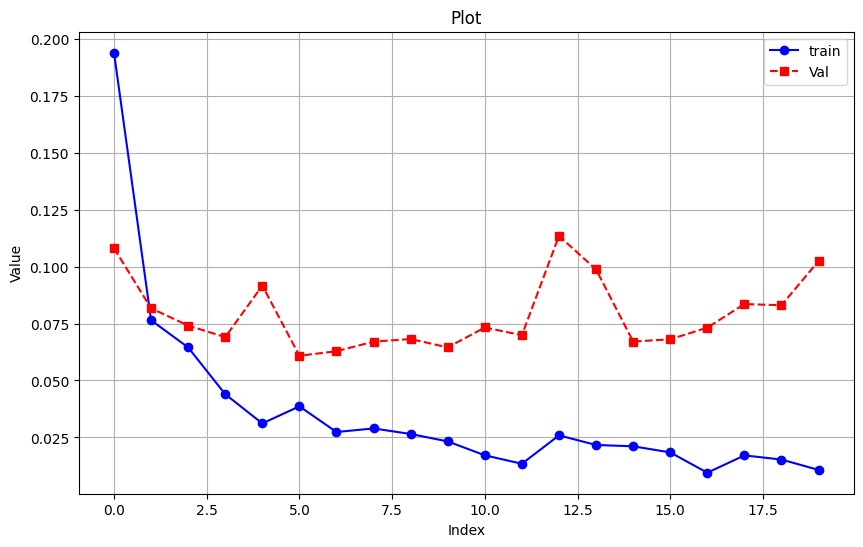

In [18]:
indices =list(range(len(train_loss)))

plt.figure(figsize=(10, 6))
plt.plot(indices, train_loss, marker='o', linestyle='-', color='b', label='train')
plt.plot(indices, val_los, marker='s', linestyle='--', color='r', label='Val')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot')
plt.legend()
plt.grid(True)
plt.show()

# 1. Network Sonrası Elde edilen değerleri Sınıflandırma Networkü için Ön işleme

**İlk verisetinin Validasyonu için feature ön işleme**

In [20]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in val_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        all_features.append(features)
        all_labels.append(anchor_label)



all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)


dataset = FeatureDataset(all_features, all_labels)

Feature_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

**Test veriseti için feature ön işleme**

In [21]:
model.eval()
test_features = []
test_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in test_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        test_features.append(features)
        test_labels.append(anchor_label)

test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

dataset_test = FeatureDataset(test_features, test_labels)

Feature_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Sınıflandırma için Train ve Test

In [22]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [23]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy




In [24]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [25]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [26]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:01<00:26,  1.37s/it]

Epoch 1/20, Training Loss: 0.2671, Training Accuracy: 0.9132
Validation Loss: 0.1724, Validation Accuracy: 94.32%


Epochs:  10%|█         | 2/20 [00:02<00:23,  1.33s/it]

Epoch 2/20, Training Loss: 0.1598, Training Accuracy: 0.9426
Validation Loss: 0.1548, Validation Accuracy: 94.59%


Epochs:  15%|█▌        | 3/20 [00:03<00:22,  1.32s/it]

Epoch 3/20, Training Loss: 0.1478, Training Accuracy: 0.9456
Validation Loss: 0.1635, Validation Accuracy: 94.44%


Epochs:  20%|██        | 4/20 [00:05<00:20,  1.29s/it]

Epoch 4/20, Training Loss: 0.1463, Training Accuracy: 0.9476
Validation Loss: 0.1485, Validation Accuracy: 94.80%


Epochs:  25%|██▌       | 5/20 [00:06<00:19,  1.28s/it]

Epoch 5/20, Training Loss: 0.1422, Training Accuracy: 0.9489
Validation Loss: 0.1452, Validation Accuracy: 94.80%


Epochs:  30%|███       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 6/20, Training Loss: 0.1331, Training Accuracy: 0.9498
Validation Loss: 0.1466, Validation Accuracy: 94.77%


Epochs:  35%|███▌      | 7/20 [00:08<00:16,  1.25s/it]

Epoch 7/20, Training Loss: 0.1328, Training Accuracy: 0.9512
Validation Loss: 0.1320, Validation Accuracy: 95.10%


Epochs:  40%|████      | 8/20 [00:10<00:15,  1.25s/it]

Epoch 8/20, Training Loss: 0.1287, Training Accuracy: 0.9527
Validation Loss: 0.1381, Validation Accuracy: 95.21%


Epochs:  45%|████▌     | 9/20 [00:11<00:13,  1.26s/it]

Epoch 9/20, Training Loss: 0.1267, Training Accuracy: 0.9516
Validation Loss: 0.1388, Validation Accuracy: 94.94%


Epochs:  50%|█████     | 10/20 [00:12<00:12,  1.28s/it]

Epoch 10/20, Training Loss: 0.1229, Training Accuracy: 0.9533
Validation Loss: 0.1361, Validation Accuracy: 95.16%


Epochs:  55%|█████▌    | 11/20 [00:14<00:11,  1.27s/it]

Epoch 11/20, Training Loss: 0.1221, Training Accuracy: 0.9526
Validation Loss: 0.1409, Validation Accuracy: 94.70%


Epochs:  60%|██████    | 12/20 [00:15<00:10,  1.27s/it]

Epoch 12/20, Training Loss: 0.1172, Training Accuracy: 0.9544
Validation Loss: 0.1338, Validation Accuracy: 94.95%


Epochs:  65%|██████▌   | 13/20 [00:16<00:08,  1.27s/it]

Epoch 13/20, Training Loss: 0.1191, Training Accuracy: 0.9556
Validation Loss: 0.1259, Validation Accuracy: 95.11%


Epochs:  70%|███████   | 14/20 [00:17<00:07,  1.29s/it]

Epoch 14/20, Training Loss: 0.1141, Training Accuracy: 0.9550
Validation Loss: 0.1348, Validation Accuracy: 95.30%


Epochs:  75%|███████▌  | 15/20 [00:19<00:06,  1.31s/it]

Epoch 15/20, Training Loss: 0.1140, Training Accuracy: 0.9565
Validation Loss: 0.1347, Validation Accuracy: 95.08%


Epochs:  80%|████████  | 16/20 [00:20<00:05,  1.30s/it]

Epoch 16/20, Training Loss: 0.1110, Training Accuracy: 0.9567
Validation Loss: 0.1391, Validation Accuracy: 95.12%


Epochs:  85%|████████▌ | 17/20 [00:21<00:03,  1.28s/it]

Epoch 17/20, Training Loss: 0.1110, Training Accuracy: 0.9568
Validation Loss: 0.1433, Validation Accuracy: 95.00%


Epochs:  90%|█████████ | 18/20 [00:23<00:02,  1.28s/it]

Epoch 18/20, Training Loss: 0.1107, Training Accuracy: 0.9589
Validation Loss: 0.1233, Validation Accuracy: 95.49%


Epochs:  95%|█████████▌| 19/20 [00:24<00:01,  1.27s/it]

Epoch 19/20, Training Loss: 0.1046, Training Accuracy: 0.9595
Validation Loss: 0.1246, Validation Accuracy: 95.45%


Epochs: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

Epoch 20/20, Training Loss: 0.1014, Training Accuracy: 0.9606
Validation Loss: 0.1162, Validation Accuracy: 95.51%


In [27]:
torch.save(classificationModel.state_dict(), "houst_classification_triplet_model.pth")

# Değerlendirme

In [28]:

X_tensor = torch.tensor(X).float().to(device)
y_pred_array = []
i=0
while i <  X_tensor.shape[0]:
      a =  X_tensor[i]
      a = a.unsqueeze(0)
      output=model(a)
      clas_tahmin = classificationModel(output)
      clas_tahmin =clas_tahmin.argmax().float()
      clas_tahmin=clas_tahmin.item()
      y_pred_array.append(clas_tahmin)
      i+=1




**Başarı skorları**

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score


s=accuracy_score(y,y_pred_array)
c=cohen_kappa_score(y,y_pred_array)
f1=f1_score(y,y_pred_array,average='weighted')
print("Accuracy:",s)
print("Cohen Kappa Score:",c)
print("F1 Score:",f1)

Accuracy: 0.9619360902255639
Cohen Kappa Score: 0.9356251562500196
F1 Score: 0.9609885462910365


In [30]:
gt_2=np.array(houston18_gt_file['map'])

In [31]:
gt_2=gt_2.reshape(-1)

In [32]:
a=gt_2.shape[0]

In [33]:
gt_3=np.array(houston18_gt_file['map'])

In [34]:

d=0
i=0
for i in range(a):
    if gt_2[i] != 0:
              gt_2[i]=(y_pred_array[d] + 1)
              d += 1

gt_2=gt_2.reshape(954,-1)

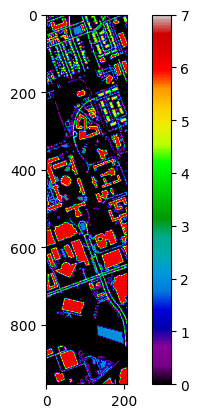

In [35]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.colorbar()

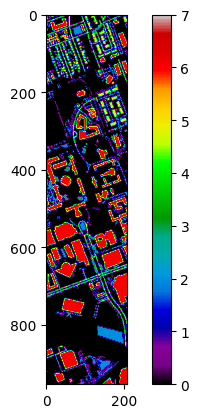

In [36]:
plt.imshow(gt_2,cmap='nipy_spectral')
plt.colorbar()